In [1]:
!pip uninstall tensorflow tensorflow-addons keras -y
!pip install tensorflow==2.9.0 keras==2.9.0 tensorflow-addons==0.18.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installati

In [2]:
import zipfile

In [3]:
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation , GlobalAveragePooling2D ,DepthwiseConv2D ,Input ,Add ,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping , LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [4]:
# zip_path = "/content/drive/MyDrive/train.zip"  # Path to the ZIP file
# extracted_path = "/content/chest_ctscan_images"  # Path to extract the files
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_path)

In [5]:
main_dir = "/kaggle/input/ct-scan/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

In [6]:
train_dir = "/kaggle/working/ct-scan/train"
valid_dir = "/kaggle/working/ct-scan/valid"
test_dir = "/kaggle/working/ct-scan/test"

In [7]:
def split_data(source_dir, train_dir, valid_dir, test_dir, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_train_path = os.path.join(train_dir, class_name)
        class_valid_path = os.path.join(valid_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        # Create subdirectories for each class if they don't exist
        os.makedirs(class_train_path, exist_ok=True)
        os.makedirs(class_valid_path, exist_ok=True)
        os.makedirs(class_test_path, exist_ok=True)

        all_files = os.listdir(class_source_path)
        random.shuffle(all_files)  # Shuffle the files randomly

        # Calculate split indices
        train_end = int(len(all_files) * train_ratio)
        valid_end = train_end + int(len(all_files) * valid_ratio)

        # Split the files
        train_files = all_files[:train_end]
        valid_files = all_files[train_end:valid_end]
        test_files = all_files[valid_end:]

        # Move files to respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_train_path, file))
        for file in valid_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))
        for file in test_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_test_path, file))


# Call the function to split the data
split_data(main_dir, train_dir, valid_dir, test_dir)

In [8]:
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

In [9]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 767 images belonging to 3 classes.


In [11]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 219 images belonging to 3 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 111 images belonging to 3 classes.


In [13]:
os.makedirs(test_dir, exist_ok=True)


In [14]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 3


In [15]:
print("Test directory:", test_dir)


Test directory: /kaggle/working/ct-scan/test


In [16]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [17]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=3, average="micro", name='f1_score')
]

In [18]:
# Define the input
input_layer = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 3
block3_output = Conv2D(96, (3,3), activation='relu', padding='same')(x)
block3_output = BatchNormalization()(block3_output)
block3_output = MaxPooling2D((2, 2))(block3_output)

# Block 4
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(block3_output)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
block4_branch = Conv2D(64, (1,1), activation='relu', padding='same')(x)
x = Conv2D(160, (3, 3), activation='relu', padding='same')(block4_branch)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
block4_output = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# block3_out = Conv2D(32, (1,1), activation='relu', padding='same')(block3_output)
# block3_out = Conv2D(96, (3, 3), activation='relu', padding='same', dilation_rate=2)(block3_out)
x = Concatenate()([block4_output,  block3_output])
x = MaxPooling2D((2, 2))(x)

# Block 5
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(192, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(96, (1,1), activation='relu', padding='same')(x)
x = Conv2D(224, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# MaxPooling before Block 6
main_branch_output = MaxPooling2D((2, 2))(x)
main_branch_output = BatchNormalization()(main_branch_output)

parallel_branch = DepthwiseConv2D(kernel_size=(5,5) ,activation='relu')(block4_branch)
parallel_branch = Conv2D(64, (3,3),padding='same', dilation_rate=2)(parallel_branch)
parallel_branch = BatchNormalization()(parallel_branch)
parallel_branch = ReLU()(parallel_branch)
parallel_branch = MaxPooling2D((2, 2))(parallel_branch)
parallel_branch = DepthwiseConv2D(kernel_size=(5,5) ,activation='relu')(parallel_branch)
# parallel_branch = DepthwiseConv2D(kernel_size=(5,5),activation='relu')(parallel_branch)
parallel_branch = BatchNormalization()(parallel_branch)

main_branch_gap = GlobalAveragePooling2D()(main_branch_output)
parallel_branch_gap = GlobalAveragePooling2D()(parallel_branch)

# Concatenate the GAP outputs
x = Concatenate()([main_branch_gap, parallel_branch_gap])
# x = GlobalAveragePooling2D()(main_branch_output)

# Output layer
output_layer = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

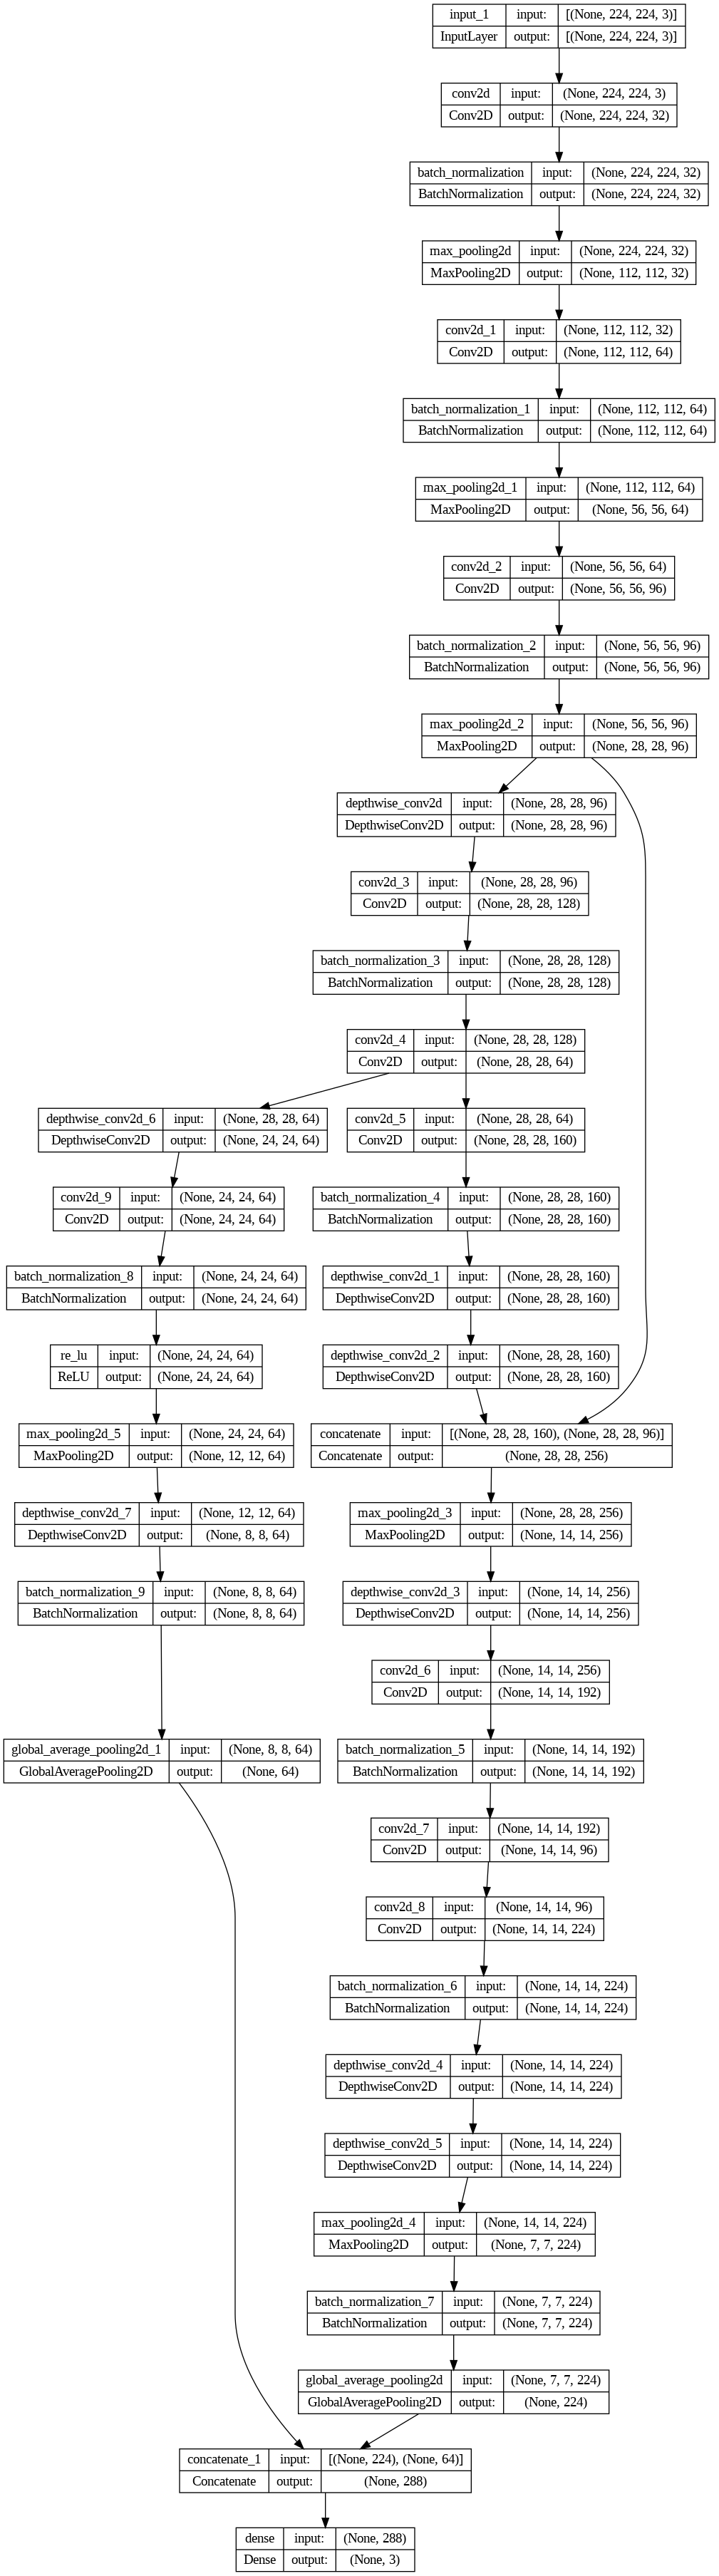

In [19]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [20]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [21]:
def lr_schedule(epoch,learning_rate):
  if epoch <7:
    return learning_rate
  else:
    return 0.95*learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

In [22]:
# print("Length of train_dataset:", len(train_dataset))
# print("Length of valid_dataset:", len(valid_dataset))

In [23]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)#,
    # EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
]

In [24]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[callbacks, lr_scheduler],
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.8044 - precision: 0.8736 - recall: 0.7027 - auc: 0.9342 - f1_score: 0.8044
Epoch 1: val_accuracy improved from -inf to 0.51142, saving model to best_model.keras
48/48 [==============================] - 75s 2s/step - loss: 0.5216 - accuracy: 0.8044 - precision: 0.8736 - recall: 0.7027 - auc: 0.9342 - f1_score: 0.8044 - val_loss: 1.0177 - val_accuracy: 0.5114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7343 - val_f1_score: 0.5114 - lr: 5.0000e-04
Epoch 2/25
48/48 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9048 - precision: 0.9104 - recall: 0.8748 - auc: 0.9810 - f1_score: 0.9048
Epoch 2: val_accuracy did not improve from 0.51142
48/48 [==============================] - 70s 1s/step - loss: 0.2753 - accuracy: 0.9048 - precision: 0.9104 - recall: 0.8748 - auc: 0.9810 - f1_score: 0.9048 - val_loss: 0.9905 - val_accuracy: 0.5114 - val_precision: 0.5114 - 

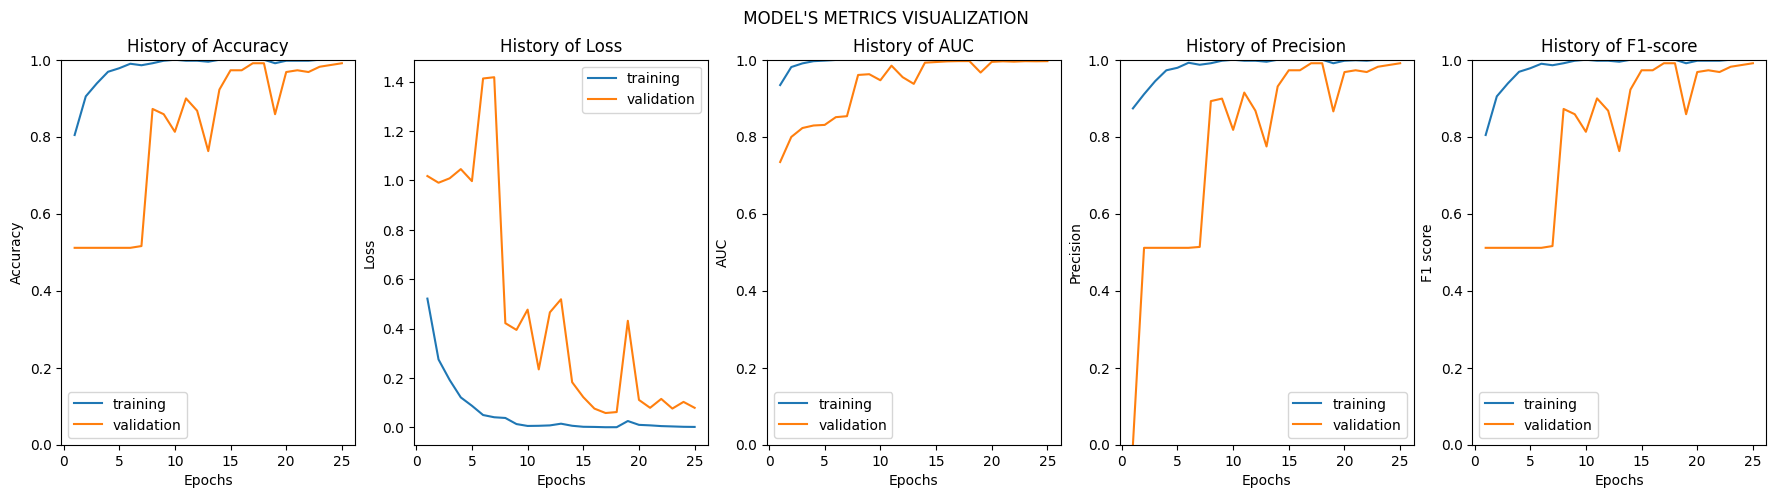

In [25]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [26]:
model.evaluate(test_generator)

7/7 [==============================] - 2s 343ms/step - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000


[0.008108217269182205, 1.0, 1.0, 1.0, 1.0, 1.0]

In [27]:
X_test, y_test = [], []
for i in range(len(test_generator)):
    batch_X, batch_y = test_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

# Print the classification report
print(report)

4/4 [==============================] - 3s 584ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        42

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

